### Simple Histogram Fitting Example in ROOT

This example shows how to fit an histogram using ROOT 

Create First an empty histogram with 50 bins with range [-10,10]

In [1]:
TH1D h1("h1","h1",50,-10,10);

(TH1D &) Name: h1 Title: h1 NbinsX: 50


Fill the histogram with 10000 Gaussian Random number with mean=1 and sigma=2

In [2]:
for (int i = 0; i < 1000; ++i) { h1.Fill(gRandom->Gaus(1,2));}

We could also use the function h1.FillRandom("gaus"), but we need to set the right parameters of the Gaussian function before.

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


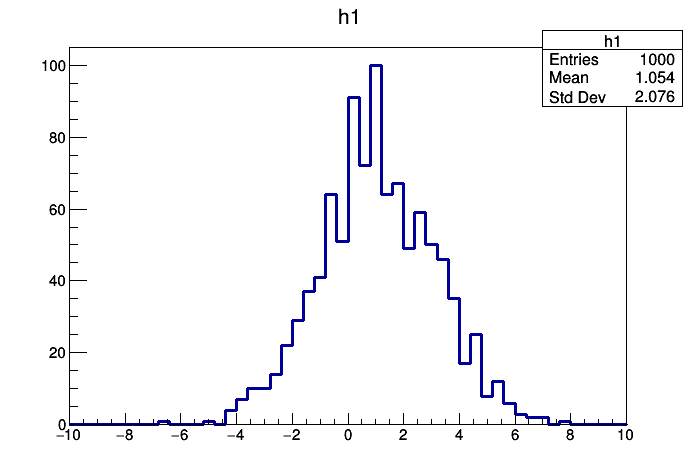

In [3]:
h1.Draw(); gPad->Draw();

Before Fitting we need to create the fitting function and set its initial parameter values. 
For a Gaussian function in reality is not needed, because they can be computed automatically. 

In [4]:
// declare here some variables which will be used afterwards
TF1 * f1 = nullptr; 
TFitResultPtr res; 

In [5]:
f1 = new TF1("f1","gaus",-10,10);

In [6]:
f1->SetParameters(100,0,1);  

We fit now the histogram using the Fit method in ROOT. By default the least-square method is used. 
For likelihood fits we need to use the option "L". 
The option "S" is used to create a TFitResult object that is returned to the user.
If we want to compute the error using MINOS, we use the "E" option
We want to change also the default Minimization engine. We will use Minuit2

In [7]:
ROOT::Math::MinimizerOptions::SetDefaultMinimizer("Minuit2");

In [9]:
res = h1.Fit(f1, "S  E")


****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      35.8313
NDf                       =           29
Edm                       =  1.53927e-06
NCalls                    =           61
Constant                  =      74.0249   +/-   3.02719     
Mean                      =      1.02272   +/-   0.0685141   
Sigma                     =      2.08778   +/-   0.0545989    	 (limited)
(TFitResultPtr &) @0x7fff781fcc60


In [10]:
gStyle->SetOptFit(1);

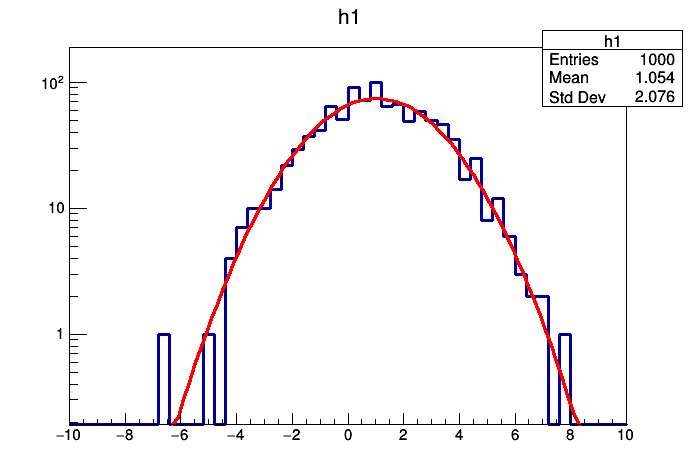

In [10]:
gPad->SetLogy(true); // to set log scale in y
gPad->Draw();

We can now print the result of the Fit

In [11]:
res->Print();


****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      35.8313
NDf                       =           29
Edm                       =  1.53927e-06
NCalls                    =           61
Constant                  =      74.0249   +/-   3.02719     
Mean                      =      1.02272   +/-   0.0685141   
Sigma                     =      2.08778   +/-   0.0545989    	 (limited)


We now get the corre;ation matrix of the fit from the TFitResult class

In [12]:
auto corrMatrix = res->GetCorrelationMatrix(); 

In [13]:
corrMatrix.Print(); 


3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |          1    0.007831     -0.6162 
   1 |   0.007831           1    -0.02075 
   2 |    -0.6162    -0.02075           1 



In [14]:
std::cout  << "Gaussian sigma = " << f1->GetParameter("Sigma") << "  +/- " << f1->GetParError(f1->GetParNumber("Sigma")) << std::endl;

Gaussian sigma = 2.08778  +/- 0.0545989


If we want to access the MINOS asymmetric error, we can get them from the FitResult object

In [15]:
std::cout  << "Gaussian sigma = " << res->Parameter(2) << "  + " << res->UpperError(2) << "  " << res->LowerError(2) << std::endl;

Gaussian sigma = 2.08778  + 0.0546934  -0.0545425


#### Part 2:  Fit Bias Study

We study now the Fit Bias for the sigma parameter. We look at the difference obtained by using 3 different fit methods: 

1. Chisquare fit using the observed error (default case in ROOT) 
2. Chisquare fit using the expected error (option "P" - Pearson chi2)
3. Binned maximum likelihood fit (option "L")

In [17]:
TH1 * hs = nullptr;

In [16]:
hs = new TH1D("hs","Sigma pull distribution",50,-4,4);

In [21]:
hs->Reset(); // in case we run a second time
for (int iexp = 0; iexp < 1000; ++iexp) { 
    TH1D h0("h0","h0",50,-10,10);
    for (int i = 0; i < 1000; ++i){
        h0.Fill(gRandom->Gaus(0,2));
    }
    TF1 f1("f1","gaus",-10,10);
    f1.SetParameters(100,0,1);
    h0.Fit(&f1,"Q  ");  // use Q option to avoid too much printing
    hs->Fill( (f1.GetParameter(2)- 2)/f1.GetParError(2));  // to get sigma and its error
    //std::cout << f1.GetParameter(2) << " " << f1.GetParError(2) << std::endl;
}

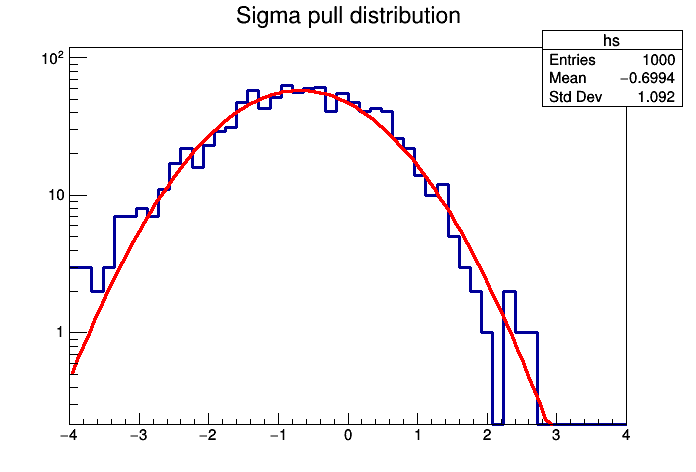


****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =       36.432
NDf                       =           38
Edm                       =  3.97241e-10
NCalls                    =           61
Constant                  =      57.7448   +/-   2.36571     
Mean                      =    -0.688767   +/-   0.036018    
Sigma                     =      1.06303   +/-   0.0275047    	 (limited)


In [22]:
hs->Fit("gaus"); gPad->Draw();

#### Part 3:  Study the chi2 distribution

Using the likelihood definition described in the Baker-Cousins paper we can use the likelihood at the minimum as a chi2. We study its distribution using pseudo-experiments.
We can compare what we obtain if we use the likelihood-value or the emperical chi2 obtained from the data/function residuals. 

In [ ]:
TH1 * hchi = nullptr;
TF1 * fchi = nullptr; 

In [1]:
hchi = new TH1D("hchi","chi-squared distribution",100,0,100);

In [2]:
hchi->Reset(); // in case we run a second time
for (int iexp = 0; iexp < 10000; ++iexp) { 
    TH1D h0("h0","h0",50,-10,10);
    for (int i = 0; i < 1000; ++i){
        h0.Fill(gRandom->Gaus(0,4));
    }
    TF1 f1("f1","gaus",-10,10);
    f1.SetParameters(100,0,1);
    auto r = h0.Fit(&f1,"S Q L ");  // use Q option to avoid too much printing
    hchi->Fill( 2.* r->MinFcnValue() );  // to get likelihood value from fit result
    //hchi->Fill( r->Chi2 () );  //  get chi2 value from fit result
}

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


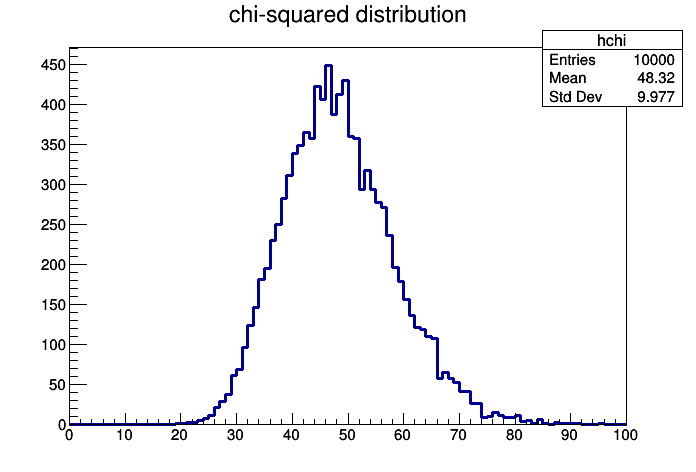

In [5]:
hchi->Draw(); gPad->Draw();

In [6]:
fchi = new TF1("fchi","[0]*ROOT::Math::chisquared_pdf(x,[1])",0,100);
fchi->SetParameters(hchi->GetEntries()*hchi->GetBinWidth(1), hchi->GetMean());

In [7]:
hchi->Fit(fchi,"L");

 FCN=40.9093 FROM MIGRAD    STATUS=CONVERGED      27 CALLS          28 TOTAL
                     EDM=3.11097e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00002e+04   1.00002e+02   4.44227e-01   1.67106e-07
   2  p1           4.83005e+01   9.72822e-02   4.32282e-04  -5.47017e-04
                               ERR DEF= 0.5


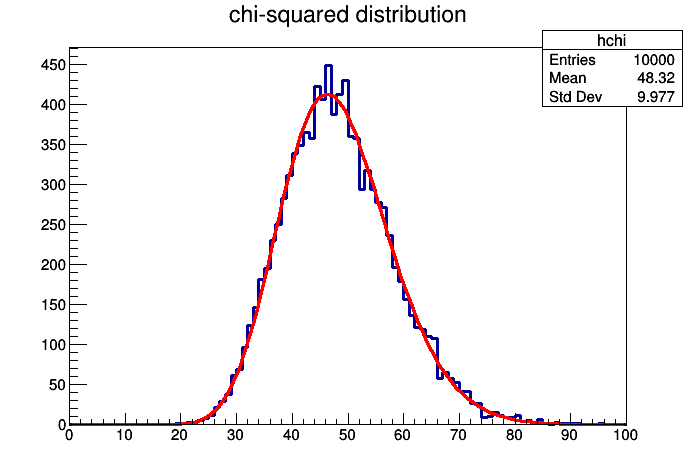

In [8]:
hchi->Draw(); gPad->Draw();